# MazeDrone with TF Agents

First attempt with polar distance added.

**Rewards:**
- destroyed = -51.
- stucked = 0.
- reached_target = 300.
- standard = -1.

### Setup

In [1]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

from __future__ import absolute_import, division, print_function



import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.metrics import tf_metrics
# from tf_agents.networks import sequential
# from tf_agents.policies import random_tf_policy
# from tf_agents.specs import tensor_spec
from tf_agents.utils import common

import sys
import gym
import gym_maze

2024-06-21 08:00:58.556276: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 08:00:58.723279: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 08:00:59.337451: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 08:01:00.831355: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Hyperparameters

In [2]:
num_iterations = 10_000 # @param {type:"integer"}

initial_collect_steps = 64  # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
#replay_buffer_max_length = 100000  # @param {type:"integer"}
replay_buffer_max_length = 100  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 100  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

### Environment

In [3]:
# Some necessary imports 
#sys.path.append('/home/naski/Documents/dev/maze_drone_v02/maze-drone-v02/lib/python3.10/site-packages')


In [4]:
# Importing custom environment
env_name = 'maze-v0'
env = suite_gym.load(env_name)

# Testing
env.reset()

TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([1.       , 1.       , 0.       , 1.       , 2.       , 1.5707964],
      dtype=float32)})

Usually two environments are instantiated: one for training and one for evaluation.

In [5]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

# Converts environments, originally in pure Python, to tensors (using a wrapper)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

### Agent

In [6]:
from resources import build_agent

fc_layer_params = (200,) # fc = fully connected
agent = build_agent(fc_layer_params, env, learning_rate, train_env)

agent.initialize()

### Policies


In [7]:
# The main policy that is used for evaluation and deployment.
eval_policy = agent.policy
# A second policy that is used for data collection.
collect_policy = agent.collect_policy

### Metrics and Evaluation

In [8]:
from resources import compute_avg_return

### New Observer

In [9]:
from resources import MyMetric

# Create an instance of MyMetric
my_metric = MyMetric()

### Replay Buffer

In [10]:
from tf_agents.drivers import dynamic_step_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer

In [11]:
replay_buffer_capacity = replay_buffer_max_length

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

num_episodes = tf_metrics.NumberOfEpisodes()
env_steps = tf_metrics.EnvironmentSteps()

# Add an observer that adds to the replay buffer:
replay_observer = [replay_buffer.add_batch, num_episodes, env_steps, my_metric]

### Data Collection

In [12]:
# Data collection:
collect_op = dynamic_step_driver.DynamicStepDriver(
  train_env,
  agent.collect_policy,
  observers=replay_observer,
  num_steps=collect_steps_per_iteration).run()

In [13]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=train_env.batch_size,
    num_steps=2).prefetch(3)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [14]:
iterator = iter(dataset)

In [15]:
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=replay_observer,
    num_steps=collect_steps_per_iteration)

In [16]:
time_step = train_py_env.reset()

In [17]:
time_step, _ = collect_driver.run()


In [18]:
iterator.next()

(Trajectory(
 {'step_type': <tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[0, 1]], dtype=int32)>,
  'observation': <tf.Tensor: shape=(1, 2, 6), dtype=float32, numpy=
 array([[[0.       , 0.       , 1.       , 1.       , 1.       ,
          1.5707964],
         [0.       , 0.       , 1.       , 1.       , 1.       ,
          1.5707964]]], dtype=float32)>,
  'action': <tf.Tensor: shape=(1, 2), dtype=int64, numpy=array([[3, 1]])>,
  'policy_info': (),
  'next_step_type': <tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[1, 1]], dtype=int32)>,
  'reward': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-6., -6.]], dtype=float32)>,
  'discount': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 1.]], dtype=float32)>}),
 BufferInfo(ids=<tf.Tensor: shape=(1, 2), dtype=int64, numpy=array([[0, 1]])>, probabilities=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>))

### Training the Agent

In [19]:
%%time

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()
train_py_env.set_mode(1)
eval_py_env.set_mode(1)
#train_env.set_mode(1)
#eval_env.set_mode(1)

# Create a driver to collect experience.
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=replay_observer,
    num_steps=collect_steps_per_iteration)

iterator = iter(dataset)

loss_log = []
step_log = []
steps_per_episode_log = []
episodes_per_log_interval = []
previous_n_episodes = 0

my_metric_log = []

avg_steps_per_episode_per_eval_interval = []

for _ in range(num_iterations):

    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_driver.run()

    dataset = replay_buffer.as_dataset(
        num_parallel_calls=3,
        sample_batch_size=train_env.batch_size,
        num_steps=2).prefetch(3)
        
    # Sample a batch of data from the buffer and update the agent's network.
    trajectories, _ = next(iterator)
    train_loss = agent.train(experience=trajectories).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
        step_log.append(step)
        loss_log.append(train_loss)
        episodes_per_log_interval.append(num_episodes.result().numpy() - previous_n_episodes)
        steps_per_episode_log.append(log_interval / (episodes_per_log_interval[-1]))
        previous_n_episodes = num_episodes.result().numpy()

    if step % eval_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)
        avg_steps_per_episode_per_eval_interval.append(eval_interval / sum(episodes_per_log_interval[-10:]))
        print('Avg of Steps/Episode: {:.2f}'.format(avg_steps_per_episode_per_eval_interval[-1]) )

        current_value = my_metric.result()
        my_metric_log.append(current_value)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 100: loss = 36.0
step = 200: loss = 8.680591583251953
step = 300: loss = 36.00000762939453
step = 400: loss = 204.0291748046875
step = 500: loss = 19.91014862060547
step = 600: loss = 0.07171114534139633
step = 700: loss = 2.0803513526916504
step = 800: loss = 0.0013986892299726605
step = 900: loss = 0.0
step = 1000: loss = 3.497427463531494
step = 1000: loss = 3.497427463531494
step = 1000: Average Return = 8.800000190734863
Avg of Steps/Episode: 10.99
step = 1100: loss = 9.179097175598145
step = 1200: loss = 0.0
step = 1300: loss = 0.20242570340633392
step = 1400: loss = 7.1828155517578125
step = 1500: loss = 44.93096923828125
step = 1600: loss = 0.0
step = 1700: loss = 1.7197588682174683
step = 1800: loss = 10.086956024169922
step = 1900: loss = 

## Visualization

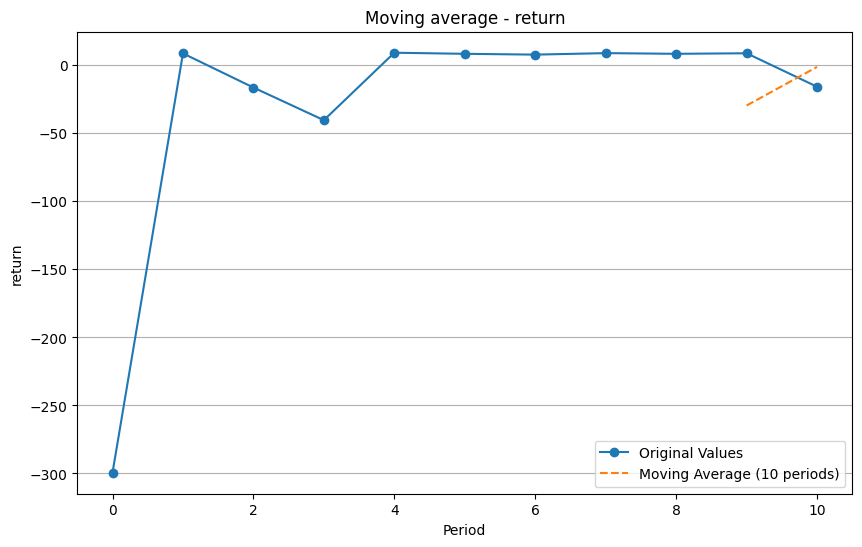

In [20]:
from resources import plot_moving_avg
plot_moving_avg('return', returns)

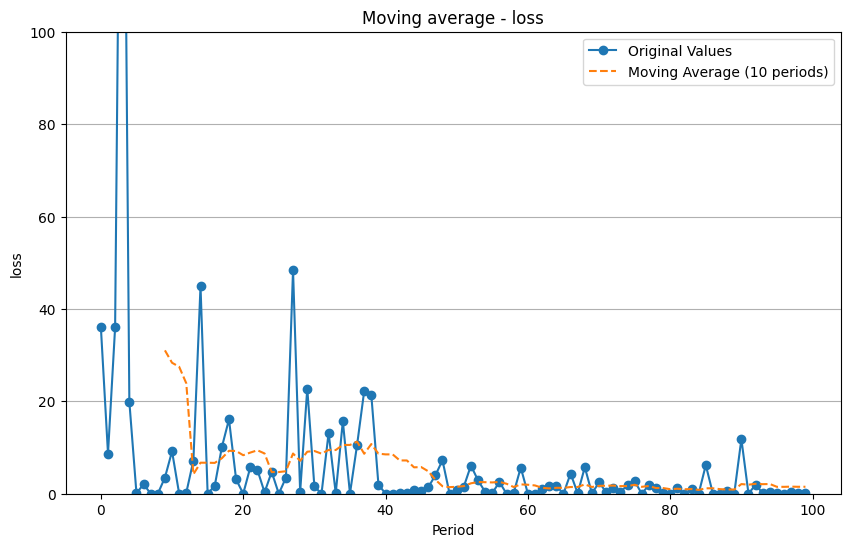

In [21]:
plot_moving_avg('loss', loss_log, ylim=True, top_lim=1_00)

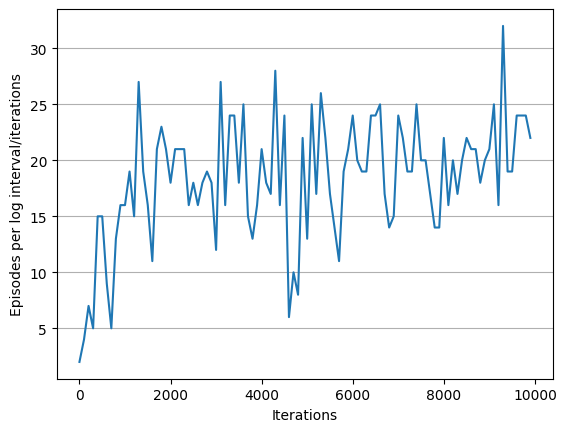

In [22]:
from resources import plot_metric_per_iteration
plot_metric_per_iteration(num_iterations, log_interval, episodes_per_log_interval, 'Episodes per log interval/iterations')

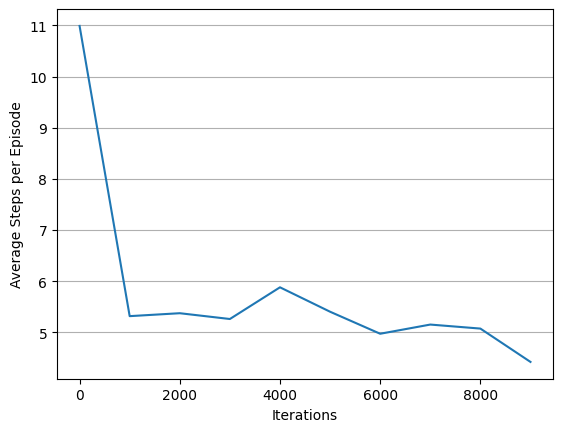

In [23]:
plot_metric_per_iteration(num_iterations, eval_interval, avg_steps_per_episode_per_eval_interval, 'Average Steps per Episode')

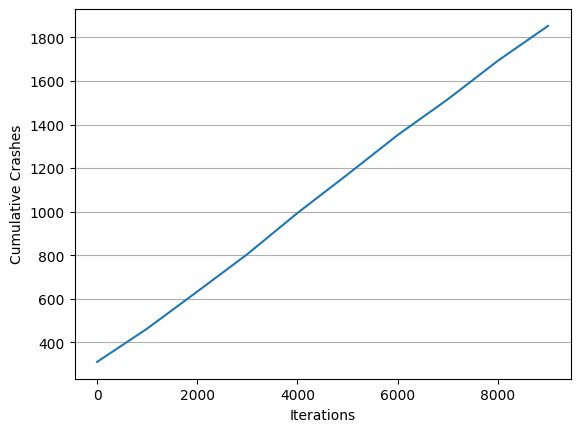

In [24]:
plot_metric_per_iteration(num_iterations, eval_interval, my_metric_log, 'Cumulative Crashes')

In [25]:
from resources import create_policy_eval_video

# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, "trained-agent", eval_env, eval_py_env)

### Keep Training 

In [26]:
%%time

num_iterations = 30_000 # @param {type:"integer"}

# Reset the environment.
time_step = train_py_env.reset()
train_py_env.set_mode(0)
eval_py_env.set_mode(0)
# train_env.set_mode(0)
# eval_env.set_mode(0)





for _ in range(num_iterations):

    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_driver.run()

    dataset = replay_buffer.as_dataset(
        num_parallel_calls=3,
        sample_batch_size=train_env.batch_size,
        num_steps=2).prefetch(3)
        
    # Sample a batch of data from the buffer and update the agent's network.
    trajectories, _ = next(iterator)
    train_loss = agent.train(experience=trajectories).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
        step_log.append(step)
        loss_log.append(train_loss)
        episodes_per_log_interval.append(num_episodes.result().numpy() - previous_n_episodes)
        steps_per_episode_log.append(log_interval / (episodes_per_log_interval[-1]))
        previous_n_episodes = num_episodes.result().numpy()

    if step % eval_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)
        avg_steps_per_episode_per_eval_interval.append(eval_interval / sum(episodes_per_log_interval[-10:]))
        print('Avg of Steps/Episode: {:.2f}'.format(avg_steps_per_episode_per_eval_interval[-1]) )

        current_value = my_metric.result()
        my_metric_log.append(current_value)

step = 10100: loss = 0.4513077437877655
step = 10200: loss = 4.1185994148254395
step = 10300: loss = 1.6667557954788208
step = 10400: loss = 34.48487091064453
step = 10500: loss = 0.6665877103805542
step = 10600: loss = 0.7261871695518494
step = 10700: loss = 11.083222389221191
step = 10800: loss = 320.1802673339844
step = 10900: loss = 2.2627782821655273
step = 11000: loss = 0.0
step = 11000: loss = 0.0
step = 11000: Average Return = -65.4000015258789
Avg of Steps/Episode: 21.28
step = 11100: loss = 2.6203811168670654
step = 11200: loss = 7.179498672485352
step = 11300: loss = 39.11406326293945
step = 11400: loss = 36.0
step = 11500: loss = 0.17894864082336426
step = 11600: loss = 24.867216110229492
step = 11700: loss = 31.7867374420166
step = 11800: loss = 31.42984390258789
step = 11900: loss = 3.8454291820526123
step = 12000: loss = 18.121431350708008
step = 12000: loss = 18.121431350708008
step = 12000: Average Return = -23.299999237060547
Avg of Steps/Episode: 13.89
step = 12100: 

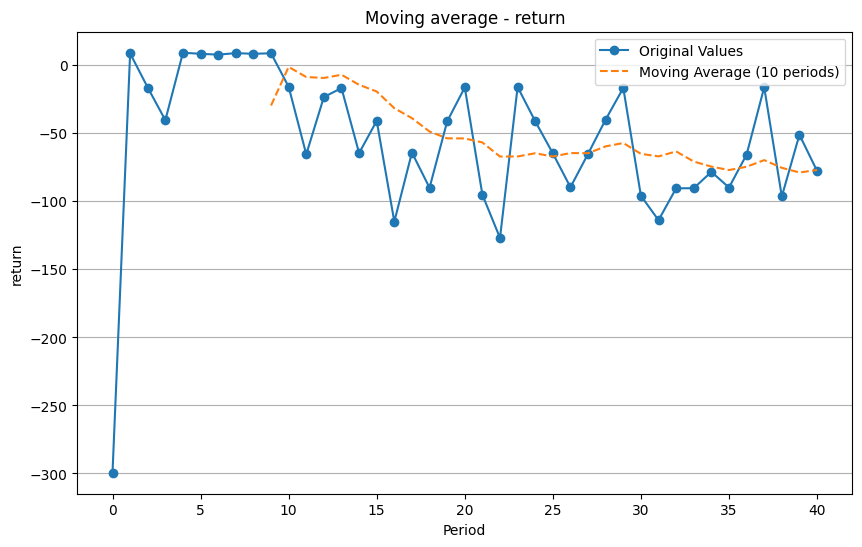

In [27]:
plot_moving_avg('return', returns)

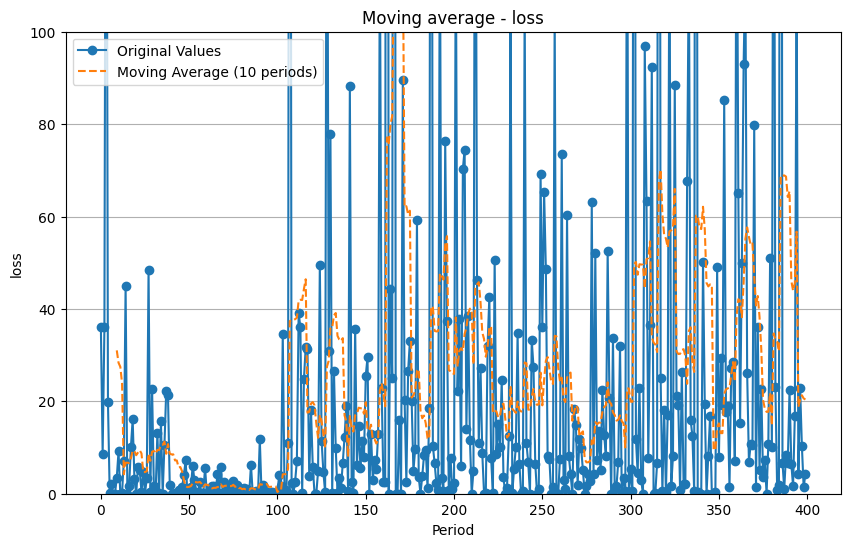

In [28]:
plot_moving_avg('loss', loss_log, ylim=True, top_lim=1_00)

In [29]:
# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, "trained-agent", eval_env, eval_py_env)